In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [2]:
transform = transforms.ToTensor()
# Get traing and test dataset
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

26427392it [00:08, 3078645.58it/s]                              


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw


32768it [00:00, 38986.72it/s]                           


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw


4423680it [00:04, 931584.84it/s]                              


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw


8192it [00:00, 14410.25it/s]            


Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw
Processing...
Done!


In [3]:
# Data loaders
num_workers = 0
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

C:\Users\matthew.millar\Anaconda3\envs\Pytorch\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


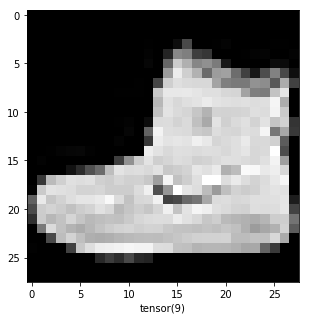

In [11]:
# Lood at data and test if loaders are working
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

img = np.squeeze(images[0]) # Get the first image
fig = plt.figure(figsize=(5,5))
plt.xlabel(str(labels[0]))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [14]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encode
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        
        self.pool = nn.MaxPool2d(2,2)
        
        # Decode
        self.conv4 = nn.Conv2d(4, 16, 3, padding=1)
        self.conv5 = nn.Conv2d(16, 1, 3, padding= 1)
    
    def forward(self,x):
        # Endocer
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # Decoder
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = F.relu(self.conv4(x))
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = F.sigmoid(self.conv5(x))
        return x

In [15]:
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [16]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
EPOCHS = 30

for epoch in range(1, EPOCHS):
    train_loss = 0.0
    
    for data in train_loader:
        images, _ = data
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = loss_function(outputs, images)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
    
    train_loss = train_loss/len(train_loader) # Average loss for the epoch
    print("Epoch:{} \tTraining Loss:{:.6f}".format(epoch, train_loss))

Epoch:1 	Training Loss:0.514478
Epoch:2 	Training Loss:0.323393
Epoch:3 	Training Loss:0.294984
Epoch:4 	Training Loss:0.276773
Epoch:5 	Training Loss:0.266297
Epoch:6 	Training Loss:0.259634
Epoch:7 	Training Loss:0.255274
Epoch:8 	Training Loss:0.252185
Epoch:9 	Training Loss:0.249541
Epoch:10 	Training Loss:0.247182
Epoch:11 	Training Loss:0.245018
Epoch:12 	Training Loss:0.243150
Epoch:13 	Training Loss:0.241625
Epoch:14 	Training Loss:0.240376
Epoch:15 	Training Loss:0.239334
Epoch:16 	Training Loss:0.238399
Epoch:17 	Training Loss:0.237554
Epoch:18 	Training Loss:0.236859
Epoch:19 	Training Loss:0.236272
Epoch:20 	Training Loss:0.235761
Epoch:21 	Training Loss:0.235317
Epoch:22 	Training Loss:0.234903
Epoch:23 	Training Loss:0.234521
Epoch:24 	Training Loss:0.234149
Epoch:25 	Training Loss:0.233798
Epoch:26 	Training Loss:0.233458
Epoch:27 	Training Loss:0.233153
Epoch:28 	Training Loss:0.232863
Epoch:29 	Training Loss:0.232583


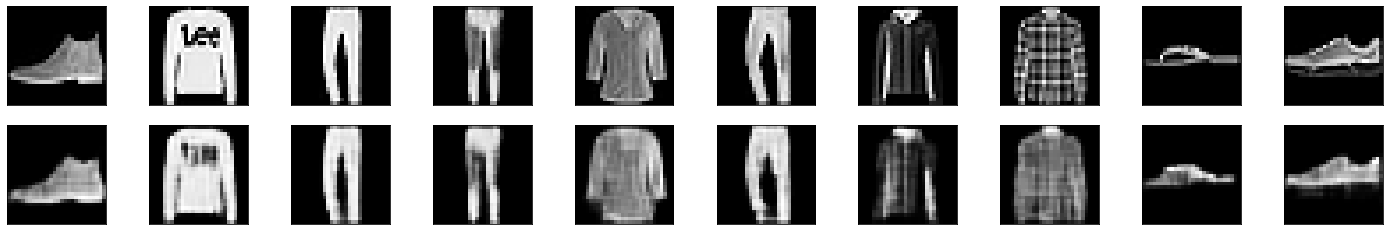

In [19]:

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)